In [1]:
from google.colab import files
uploaded = files.upload()

Saving Dataset.csv to Dataset.csv


In [2]:
from google.colab import files
uploaded = files.upload()

Saving DataTrain_with_features_2.csv to DataTrain_with_features_2.csv


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.2 MB/s eta 0:00:00


In [4]:
!pip install tldextract dnspython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 16.0 MB/s eta 0:00:00


In [5]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [6]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import time
import re
import socket
import tldextract
import dns.resolver
import math
from urllib.parse import urlparse
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

In [7]:
df_tune = pd.read_csv('Dataset.csv')
df_test = pd.read_csv('DataTrain_with_features_2.csv')

In [8]:
df_tune.shape

(247950, 42)

In [9]:
df_test.shape

(65226, 43)

In [10]:
# Chỉ lấy các cột đặc trưng và nhãn từ cùng một DataFrame
X_tune = df_tune.iloc[:, 1:]
y_tune = df_tune['label']

print(X_tune.shape, y_tune.shape)

(247950, 41) (247950,)


In [11]:
X_test = df_test.iloc[:, 2:]
y_test = df_test['label']

print(X_test.shape, y_test.shape)

(65226, 41) (65226,)


In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_tune, y_tune, test_size=0.2, stratify=y_tune, random_state=42
)

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 1200),
        "max_depth": trial.suggest_int("max_depth", 30, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.9, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.9, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "scale_pos_weight": 0.929,  # cố định vì đây là tỉ lệ nhãn
        "eval_metric": "logloss",
        "random_state": 42,
        "n_jobs": 1
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #đảm bảo mỗi fold có tỷ lệ nhãn gần giống nhau
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=1)
    return scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=36000)

[I 2025-04-21 05:04:08,122] A new study created in memory with name: no-name-e3ff418d-d2e6-4cd7-be73-2362e459bbe1
[I 2025-04-21 05:10:40,797] Trial 0 finished with value: 0.9596138334341602 and parameters: {'n_estimators': 866, 'max_depth': 87, 'learning_rate': 0.18943811411769276, 'subsample': 0.9329336520510849, 'colsample_bytree': 0.9629002910968962, 'reg_alpha': 0.7206426414747543, 'reg_lambda': 0.9926026405029946}. Best is trial 0 with value: 0.9596138334341602.
[I 2025-04-21 05:15:38,825] Trial 1 finished with value: 0.9594424279088525 and parameters: {'n_estimators': 682, 'max_depth': 71, 'learning_rate': 0.20682808460969282, 'subsample': 0.9499747990914242, 'colsample_bytree': 0.9910955565753049, 'reg_alpha': 0.35196459502012256, 'reg_lambda': 0.31660624508987867}. Best is trial 0 with value: 0.9596138334341602.
[I 2025-04-21 05:32:31,311] Trial 2 finished with value: 0.9602792901794717 and parameters: {'n_estimators': 1035, 'max_depth': 53, 'learning_rate': 0.01081301978146924

In [ ]:
# In ra kết quả tốt nhất
print("Best Accuracy:", study.best_value)
print("Best Params:", study.best_params)

Best Accuracy: 0.9606069772131478
Best Params: {'n_estimators': 990, 'max_depth': 49, 'learning_rate': 0.018942385134926715, 'subsample': 0.9293376820857115, 'colsample_bytree': 0.9726227039881513, 'reg_alpha': 0.05857563754475488, 'reg_lambda': 0.875307768173489}


Thời gian huấn luyện: 140933.08 ms


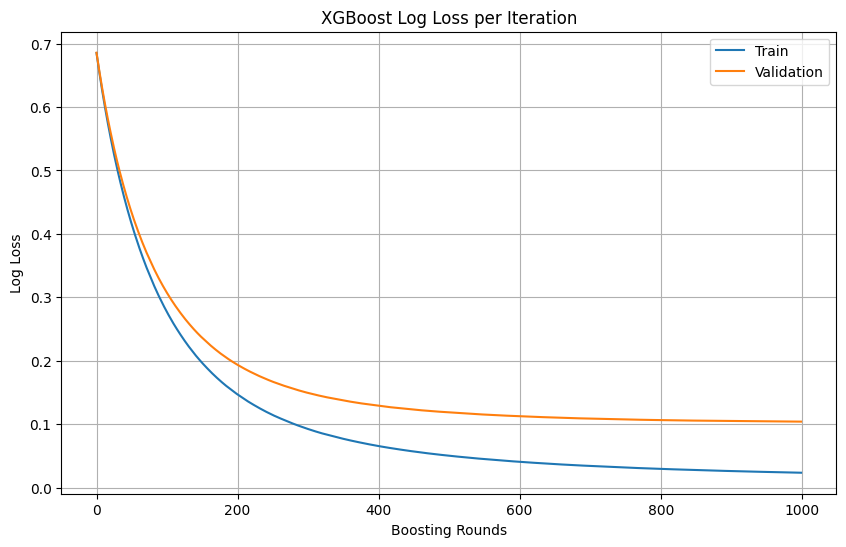

In [13]:
xgb_test = xgb.XGBClassifier(
    n_estimators=1000,        #Số lượng cây train
    max_depth=80,             #Độ sâu tối đa mỗi cây
    learning_rate=0.01,       #Tốc độ học
    subsample=0.95,           #Tỉ lệ tổng số bản ghi được dùng mỗi lần dựng 1 cây
    colsample_bytree=0.97,    #Tỉ lệ tổng số feat được dùng mỗi lần dựng 1 cây
    reg_lambda=0.9,           #Điều chỉnh feat
    reg_alpha=0.1,            #Loại bỏ feat không quan trọng
    scale_pos_weight=0.929,   #Cân bằng nhãn vì dataset mất cân bằng nhẹ
    eval_metric='logloss',
    random_state=42
)
start_time = time.time()
xgb_test.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=False
)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian huấn luyện: {elapsed_time_ms:.2f} ms")

evals_result = xgb_test.evals_result()

import matplotlib.pyplot as plt

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Train')
plt.plot(x_axis, evals_result['validation_1']['logloss'], label='Validation')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss per Iteration')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_pred = xgb_test.predict(X_valid)

acc = accuracy_score(y_valid, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

# Ma trận nhầm lẫn
print("\nConfusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

Accuracy: 96.64%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     25708
           1       0.97      0.96      0.96     23882

    accuracy                           0.97     49590
   macro avg       0.97      0.97      0.97     49590
weighted avg       0.97      0.97      0.97     49590


Confusion Matrix:
[[25019   689]
 [  978 22904]]


In [ ]:
y_pred_test = xgb_test.predict(X_test)

acc = accuracy_score(y_test, y_pred_test)
print("Accuracy: {:.2f}%".format(acc * 100))

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Ma trận nhầm lẫn
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

Accuracy: 93.28%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     32613
           1       0.93      0.94      0.93     32613

    accuracy                           0.93     65226
   macro avg       0.93      0.93      0.93     65226
weighted avg       0.93      0.93      0.93     65226


Confusion Matrix:
[[30165  2448]
 [ 1934 30679]]


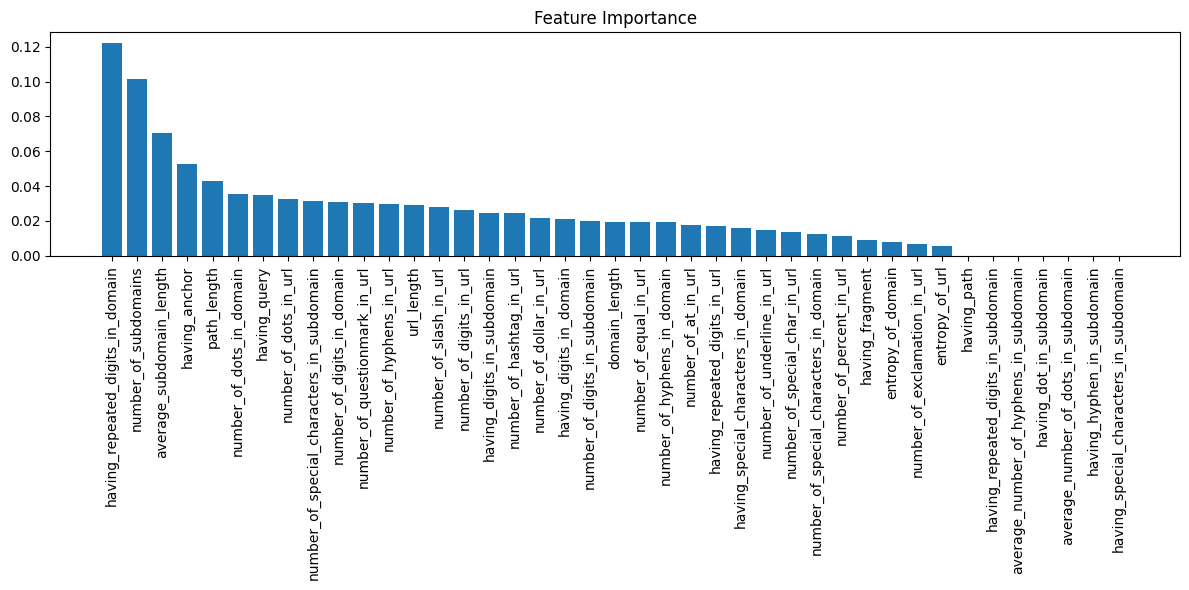

Top 3 Features quan trọng nhất:
having_repeated_digits_in_domain: 0.1221
number_of_subdomains: 0.1014
average_subdomain_length: 0.0706


In [ ]:
# Trực quan hóa Feature Importance
importances = xgb_test.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_tune.columns

plt.figure(figsize=(12,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# In ra 3 đặc trưng quan trọng nhất
top_3_features = [feature_names[i] for i in indices[:3]]
top_3_importances = importances[indices[:3]]

print("Top 3 Features quan trọng nhất:")
for i in range(3):
    print(f"{top_3_features[i]}: {top_3_importances[i]:.4f}")

In [ ]:
# Tách Features từ tập raw dataset
def calculate_entropy(string):
    prob = [float(string.count(c)) / len(string) for c in set(string)]
    return -sum(p * math.log2(p) for p in prob)

def extract_features_from_url(url):
    features = {}
    parsed = urlparse(url)
    ext = tldextract.extract(url)

    domain = ext.registered_domain or ''
    subdomain = ext.subdomain or ''
    path = parsed.path or ''
    query = parsed.query or ''
    fragment = parsed.fragment or ''

    sub_parts = subdomain.split('.') if subdomain else []

    # 1. URL_based Features
    features['url_length'] = len(url)
    features['number_of_dots_in_url'] = url.count('.')
    features['having_repeated_digits_in_url'] = int(bool(re.search(r'(\d)\1', url)))
    features['number_of_digits_in_url'] = sum(c.isdigit() for c in url)
    features['number_of_special_char_in_url'] = len(re.findall(r'[^\w]', url))
    features['number_of_hyphens_in_url'] = url.count('-')
    features['number_of_underline_in_url'] = url.count('_')
    features['number_of_slash_in_url'] = url.count('/')
    features['number_of_questionmark_in_url'] = url.count('?')
    features['number_of_equal_in_url'] = url.count('=')
    features['number_of_at_in_url'] = url.count('@')
    features['number_of_dollar_in_url'] = url.count('$')
    features['number_of_exclamation_in_url'] = url.count('!')
    features['number_of_hashtag_in_url'] = url.count('#')
    features['number_of_percent_in_url'] = url.count('%')

    # 2. Domain_based Features
    features['domain_length'] = len(domain)
    features['number_of_dots_in_domain'] = domain.count('.')
    features['number_of_hyphens_in_domain'] = domain.count('-')
    features['having_special_characters_in_domain'] = int(bool(re.search(r'[^\w\.]', domain)))
    features['number_of_special_characters_in_domain'] = len(re.findall(r'[^\w\.]', domain))
    features['having_digits_in_domain'] = int(any(c.isdigit() for c in domain))
    features['number_of_digits_in_domain'] = sum(c.isdigit() for c in domain)
    features['having_repeated_digits_in_domain'] = int(bool(re.search(r'(\d)\1', domain)))

    # 3. Subdomain_based Features
    features['number_of_subdomains'] = len(sub_parts)
    features['having_dot_in_subdomain'] = int('.' in subdomain)
    features['having_hyphen_in_subdomain'] = int('-' in subdomain)
    features['average_subdomain_length'] = np.mean([len(p) for p in sub_parts]) if sub_parts else 0
    features['average_number_of_dots_in_subdomain'] = np.mean([s.count('.') for s in sub_parts]) if sub_parts else 0
    features['average_number_of_hyphens_in_subdomain'] = np.mean([s.count('-') for s in sub_parts]) if sub_parts else 0
    features['having_special_characters_in_subdomain'] = int(bool(re.search(r'[^\w\.]', subdomain)))
    features['number_of_special_characters_in_subdomain'] = len(re.findall(r'[^\w\.]', subdomain))
    features['having_digits_in_subdomain'] = int(any(c.isdigit() for c in subdomain))
    features['number_of_digits_in_subdomain'] = sum(c.isdigit() for c in subdomain)
    features['having_repeated_digits_in_subdomain'] = int(bool(re.search(r'(\d)\1', subdomain)))

    # 4. Other Features
    features['having_path'] = int(bool(path))
    features['path_length'] = len(path)
    features['having_query'] = int(bool(query))
    features['having_fragment'] = int(bool(fragment))
    features['having_anchor'] = int('#' in url)
    features['entropy_of_url'] = calculate_entropy(url)
    features['entropy_of_domain'] = calculate_entropy(domain)

    return features


In [ ]:
model_input_columns = X_train.columns.tolist()

In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://emiratespass-online.com/mb/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 6.95 ms
Phishing


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://allegrolokalnie.id-798144.sbs")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 5.85 ms
Phishing


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://e-zpassny.com-ezoz.vip/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 8.94 ms
Phishing


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://www.facebook.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 7.98 ms
Legit


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://www.instagram.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 10.95 ms
Legit


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://www.youtube.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 8.11 ms
Phishing


In [ ]:
# Ví dụ 1 URL
features = extract_features_from_url("https://gamebanana.com/")

# Chuyển thành DataFrame và loại bỏ các cột không phải số
df_features = pd.DataFrame([features])
missing = set(model_input_columns) - set(df_features.columns)
print("Thiếu cột:", missing)
# Đảm bảo đúng thứ tự:
df_features = df_features[model_input_columns]
start_time = time.time()
prediction = xgb_test.predict(df_features)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Thời gian kiểm tra: {elapsed_time_ms:.2f} ms")
if prediction[0] == 1:
    print("Phishing")
else:
    print("Legit")

Thiếu cột: set()
Thời gian kiểm tra: 7.60 ms
Legit


In [14]:
import joblib

# Lưu model
joblib.dump(xgb_test, 'xgb_model.pkl')

['xgb_model.pkl']